In [1]:
import os
import gc 
from glob import glob
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm
import torch
import torch.nn as nn

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import scikitplot as skplt
from scikitplot.metrics import plot_cumulative_gain
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import xgboost
from collections import Counter

import shap
import pickle
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
ROOT            = Path("/kaggle/input/home-credit-risk-model-train-test")
SCHEMA_PATH     = Path("/kaggle/input/schema-home-credit-risk-data")
MODEL           = Path("/kaggle/input/homecredit-risk-model-stability/other/catboost_lgb_champ/3")
RFE             = Path("/kaggle/input/home-credit-rfe-models/other/rfe_models/1")
PRED            = Path("/kaggle/input/me-voting-estimator")
PCA             = Path("/kaggle/input/exp-pca-model-num-cols")


In [3]:
def set_data_types(df, schema):
    
    for col, dtype in schema.items():
        if dtype == 'category':
            dtype = 'object'
        df[col] = df[col].astype(dtype, errors = 'ignore')
    return df

In [4]:
X = pl.read_csv(ROOT/'model_abt_train.csv').to_pandas()
X_test = pl.read_csv(ROOT/'model_abt_test.csv').to_pandas()

schema = pd.read_csv(SCHEMA_PATH / "data_schema.csv", names = ['Columns', 'dtype'])
schema = schema[schema['Columns'].isin(X.columns)]
schema = schema.set_index('Columns')['dtype'].to_dict()

X = set_data_types(X, schema)
X_test = set_data_types(X_test, schema)
del schema

In [5]:
id_val = X[['case_id', 'WEEK_NUM']]
id_test_val = X_test[['case_id', 'WEEK_NUM']]

y = X['target']
y_test = X_test['target']

cols = X.drop(['case_id', 'WEEK_NUM', 'target', 'decision_month', 'decision_weekday'], axis = 1).columns

X = X.drop(['case_id', 'WEEK_NUM', 'target', 'decision_month', 'decision_weekday'], axis = 1)
X_test = X_test.drop(['case_id', 'WEEK_NUM', 'target', 'decision_month', 'decision_weekday'], axis = 1)

In [6]:
with open(ROOT/'cat_cols.pkl', 'rb') as f:
    cat_cols = pickle.load(f)
num_cols = [x for x, dtypes in X.dtypes.items() if dtypes in ['float', 'int']]
X[cat_cols] = X[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

In [7]:
class Model_Utils:
    @staticmethod
    def model_evals(y_true, y_proba, cutoff = 0.5):
        from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
        """
        Returns model evaluation metrics for a binary classification model

        Parameters:
        -----------
            y_true: int (0,1) 
                Actual binary labels

            y_proba: float (between 0 and 1)
                Probability scores output of model 

        Returns:
        --------
            result: dict
                Dictionary of metrics and their results based on the input
                    - event rate (% predicted 1's)
                    - accuracy
                    - roc_auc
                    - pr_auc
                    - recall
                    - precision
                    - f1
                    - lift
        """

        y_pred = (y_proba > cutoff).astype(int)

        event_rate = y_pred.mean()

        accuracy = accuracy_score(y_true, y_pred)

        roc_auc = roc_auc_score(y_true, y_proba)

        pr_auc = average_precision_score(y_true, y_proba)

        recall = recall_score(y_true, y_pred)

        precision = precision_score(y_true, y_pred)

        f1 = f1_score(y_true, y_pred)

        lift = recall / event_rate

        return {'event_rate': event_rate,
                'acc': accuracy, 
                'precision': precision, 
                'recall': recall, 
                'f1': f1, 
                'roc_auc': roc_auc,
                'pr_auc': pr_auc, 
                'lift': lift}
    
    @staticmethod
    def cutoff_perc(y_actual, y_proba, percent):
        n_cutoff = int(len(y_actual) * percent)

        scores = pd.DataFrame({'actual': y_actual, 'proba': y_proba})
        scores = scores.sort_values(by = 'proba', ascending= False)
        scores['rank'] = scores['proba'].rank(ascending = False)
        scores['ranked_pred'] = np.where(scores['rank']<= n_cutoff, 1, 0)

        print(len(scores[scores['ranked_pred'] == 1]))
        print(scores[scores['ranked_pred'] == 1]['proba'].min())
        return Model_Utils.model_evals(y_actual, y_proba, cutoff = scores[scores['ranked_pred'] == 1]['proba'].min())
    
    @staticmethod
    def DumbClassifier(y_true):
        import numpy as np
        y_pred = np.zeros(len(y_true))
        return y_pred
    
    @staticmethod
    def RandomChanceClassifier(y_true):
        import numpy as np
        y_pred = Model_Utils.DumbClassifier(y_true)
        event = y_true.sum()
        ind = np.random.randint(0, len(y_true), size=event)
        y_pred[ind] = 1
        return y_pred
    
    @staticmethod
    def save_model_results(results, schema, filepath):
        if not os.path.exists(filepath):
            score_schema = {'model_name': 'str', 
                        'model': 'str',
                        'params': 'str',
                        'acc': 'float',
                        'precision': 'float',
                        'recall': 'float',
                        'f1_score': 'float',
                        'roc_auc': 'float',
                        'pr_auc': 'float',
                        'lift': 'float'}
            scores = pd.DataFrame(columns = score_schema.keys()).astype(score_schema)
        else:
            scores = pd.read_csv(filepath)
        row = []
        
        for key in schema.keys():
            row.append(results[key])
        
        scores.loc[len(scores)] = row
        scores.to_csv(filepath, index = False)
        
    @staticmethod
    def LightGBMClassifier_CV(X, y, cat_cols, cv = 5, group = None, params = None):
        import lightgbm
        from sklearn.model_selection import StratifiedGroupKFold
        
        cv = StratifiedGroupKFold(n_splits=cv, shuffle = True, random_state = 42)
        
        if params == None:
            params = {'random_state': 42
                     ,'objective': 'binary'
                     ,'verbose': -1
                     ,'n_jobs': -1}
        
        scores = {'acc': [],
                        'precision': [],
                        'recall': [],
                        'f1': [],
                        'roc_auc': [],
                        'pr_auc': [],
                        'lift': []}

        split = 1
        
        for train_ind, valid_ind in cv.split(X, y, groups=group):
            X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
            X_valid, y_valid = X.iloc[valid_ind], y.iloc[valid_ind]

            X_train[cat_cols] = X_train[cat_cols].astype("category")
            X_valid[cat_cols] = X_valid[cat_cols].astype("category")
            
            lgb = lightgbm.LGBMClassifier(**params)
            lgb.fit(X_train, y_train)

            y_proba = lgb.predict_proba(X_valid)[:, 1]
            results = Model_Utils.model_evals(y_valid, y_proba)
            print(f'LightGBM, Val CV{split}: {results}"')
            
            split += 1
            
            for key in results.keys():
                if key in scores.keys():
                    scores[key].append(results[key])
        
        for key in results.keys():
            if key in scores.keys():
                scores[key] = np.array(scores[key]).mean()
            
        print(f'LightGBM, Average CV: {scores}"')
        return lgb, scores

    
    @staticmethod
    def LightGBMClassifier_pred(X, y, X_test, y_test, cat_cols, params = None):
        import lightgbm
        
        if params == None:
            params = {'random_state': 42
                     ,'objective': 'binary'
                     ,'verbose': -1
                     ,'n_jobs': -1}
        
        scores = {'acc': [],
                        'precision': [],
                        'recall': [],
                        'f1': [],
                        'roc_auc': [],
                        'pr_auc': [],
                        'lift': []}

        
        X[cat_cols] = X[cat_cols].astype("category")
        X_test[cat_cols] = X_test[cat_cols].astype("category")
            
        lgb = lightgbm.LGBMClassifier(**params)
        lgb.fit(X, y)

        y_proba = lgb.predict_proba(X_test)[:, 1]
        results = Model_Utils.model_evals(y_test, y_proba)
        print(f'LightGBM, Test: {results}"')
        
        return lgb, y_proba, results
    
    
    @staticmethod
    def CatBoostClassifier_CV(X, y, cat_cols, cv = 5, group = None, params = None):
        import catboost
        from sklearn.model_selection import StratifiedGroupKFold
        
        cv = StratifiedGroupKFold(n_splits=cv, shuffle = True, random_state = 42)
        
        if params == None:
             params = {'boosting_type' : "Plain",
                      'eval_metric': 'PRAUC',
                      'random_seed': 42,
                      'learning_rate': 0.05,
                      'use_best_model': True,
                      'iterations': 1000}
        
        scores = {'acc': [],
                        'precision': [],
                        'recall': [],
                        'f1': [],
                        'roc_auc': [],
                        'pr_auc': [],
                        'lift': []}

        split = 1
        
        for train_ind, valid_ind in cv.split(X, y, groups=group):
            X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
            X_valid, y_valid = X.iloc[valid_ind], y.iloc[valid_ind]
            
            
            clf = CatBoostClassifier(**params)
        
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_valid, y_valid, cat_features=cat_cols)
            
            clf.fit(train_pool, eval_set=val_pool, verbose=False)
            
            y_proba = clf.predict_proba(X_valid)[:, 1]
            results = Model_Utils.model_evals(y_valid, y_proba)
            print(f'CatBoost, Val CV{split}: {results}"')
            
            split += 1
            
            for key in results.keys():
                if key in scores.keys():
                    scores[key].append(results[key])
        
        for key in results.keys():
            if key in scores.keys():
                scores[key] = np.array(scores[key]).mean()
            
        print(f'CatBoost, Average CV: {scores}"')
        return clf, scores
    
    
    @staticmethod
    def CatBoostClassifier_pred(X, y, X_test, y_test, cat_cols, params = None):
        import catboost
    
        if params == None:
             params = {'boosting_type' : "Plain",
                      'eval_metric': 'PRAUC',
                      'random_seed': 42,
                      'learning_rate': 0.05,
                      'use_best_model': True,
                      'iterations': 1000}
                
        clf = CatBoostClassifier(**params)
        
        train_pool = Pool(X, y, cat_features=cat_cols)
        test_pool = Pool(X_test, y_test, cat_features=cat_cols)
            
        clf.fit(train_pool, eval_set=test_pool, verbose=False)
            
        y_proba = clf.predict_proba(X_test)[:, 1]
        results = Model_Utils.model_evals(y_test, y_proba)
        print(f'CatBoost, Test: {results}"')
            
        return clf, y_proba, results

    
    @staticmethod
    def train_test_split(X, y, test_size = 0.2):
        from sklearn.model_selection import train_test_split
        import polars as pl
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        pl.from_pandas(pd.concat([y_train, X_train], axis = 1)).write_csv('model_abt_train.csv')
        del X_train
        del y_train
        gc.collect()
        
        pl.from_pandas(pd.concat([y_test, X_test], axis = 1)).write_csv('model_abt_test.csv')
        del X_test
        del y_test
        gc.collect()

In [8]:
y_dumb =  Model_Utils.DumbClassifier(y)
results  = Model_Utils.model_evals(y,y_dumb)
print(results)
results['model_name'] = 'Dumb Classifier'
results['model'] = 'Predict All Major'
results['params'] = None
#Model_Utils.save_model_results(results, score_schema, "baseline.csv")
del results
gc.collect()

{'event_rate': 0.0, 'acc': 0.9685252188807748, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc_auc': 0.5, 'pr_auc': 0.031474781119225234, 'lift': nan}


0

In [9]:
y_rand = Model_Utils.RandomChanceClassifier(y)
results  = Model_Utils.model_evals(y, y_rand)
print(results)
results['model_name'] = 'Random Chance Classifier'
results['model'] = 'Randomly Predict at Event Rate'
results['params'] = None
#Model_Utils.save_model_results(results, score_schema, "baseline.csv")
del results
gc.collect()

{'event_rate': 0.030983512196160405, 'acc': 0.9394478301061059, 'precision': 0.030760286461774266, 'recall': 0.030280169610572047, 'f1': 0.03051833984426208, 'roc_auc': 0.4996369002211419, 'pr_auc': 0.03145314609981177, 'lift': 0.9772994558804241}


0

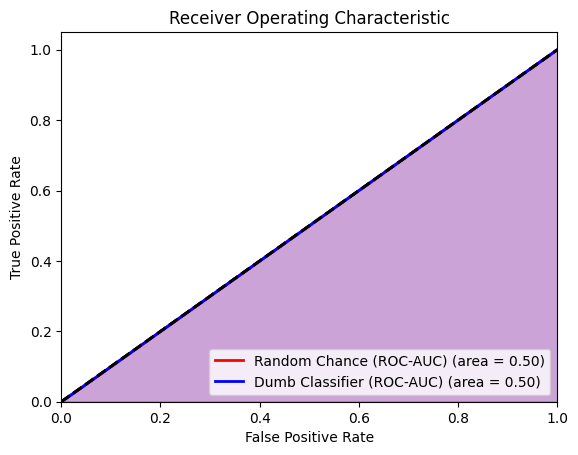

In [12]:
plot_roc(y, y_rand, 'red', 'Random Chance (ROC-AUC)')
plot_roc(y, y_rand, 'blue', 'Dumb Classifier (ROC-AUC)')

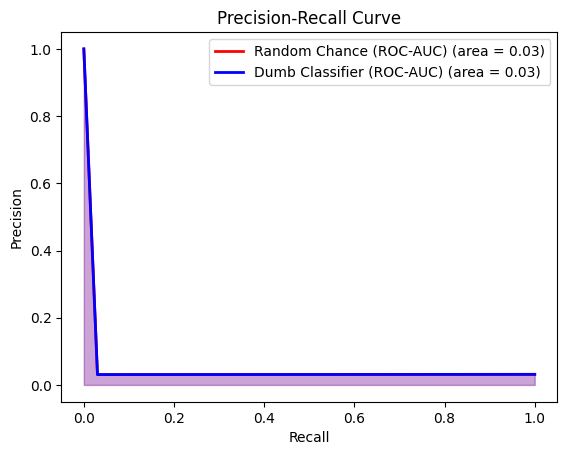

In [13]:
plot_pr(y, y_rand, 'red', 'Random Chance (ROC-AUC)')
plot_pr(y, y_rand, 'blue', 'Dumb Classifier (ROC-AUC)')

In [14]:
rfe_95 = joblib.load(RFE/'lgb_train_rfe_num_95.joblib')

In [19]:
X_test[cat_cols] = X_test[cat_cols].astype('category')

In [22]:
y_test

0         0
1         0
2         0
3         0
4         0
         ..
305327    0
305328    0
305329    0
305330    0
305331    0
Name: target, Length: 305332, dtype: int64

In [23]:
y_95 = rfe_95.predict_proba(X_test[rfe_95.feature_name_])[:,1]
Model_Utils.model_evals(y_test, y_95)

{'event_rate': 0.0009530609303970759,
 'acc': 0.9687553220756423,
 'precision': 0.5223367697594502,
 'recall': 0.015911232073694128,
 'f1': 0.030881755383990246,
 'roc_auc': 0.8560987673841617,
 'pr_auc': 0.19187688884450427,
 'lift': 16.694873922766927}

In [40]:
champ_predictions = pd.read_csv(PRED/"Test_predictions.csv")

In [41]:
champ_predictions.head()

,case_id,WEEK_NUM,target,catboost_pred,lgb_pred,credamount_770A_x,credamount_770A_y,avglnamtstart24m_4525187A,first_sex_738L,mean_depth2_pmts_dpd_303P,...,max_totalamount_6A,first_birth_259D.1,annuity_780A,min_dateofcredstart_739D,pmtnum_254L.1,max_dateofcredstart_739D,pmtssum_45A,min_dateofcredend_289D,max_residualamount_856A,lastapprcommoditycat_1041M
0,1916357,87,0,0.001453,0.001210,76986.0,76986.0,NaN,F,0.021973,...,50085.8,-23622,6747.2000,-601.0,12.0,-601.0,NaN,130.0,0.000,a55475b1
1,982288,71,0,0.003648,0.005148,21000.0,21000.0,NaN,F,60.343750,...,160000.0,-12796,2206.6000,-247.0,12.0,-141.0,NaN,484.0,5197.200,a55475b1
2,1919445,87,0,0.003869,0.001931,26900.0,26900.0,NaN,M,0.138184,...,200000.0,-20336,3342.4001,-1111.0,12.0,-68.0,NaN,350.0,56732.883,P148_110_5
3,1471876,30,0,0.006024,0.006463,36580.0,36580.0,NaN,F,0.000000,...,5112.0,-9313,3141.4001,-994.0,18.0,-315.0,5100.0,50.0,0.000,P109_133_183
4,255991,90,0,0.005158,0.005476,70000.0,70000.0,NaN,F,0.000000,...,33661.0,-24281,6327.6000,-1164.0,18.0,-211.0,NaN,49.0,0.000,a55475b1


In [11]:
def plot_roc(y_true, y_proba, color = 'red', label = 'ROC-AUC'):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.fill_between(fpr, tpr, alpha=0.2, color=color)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    #plt.show()
    
def plot_pr(y_true, y_proba, color = 'red', label = 'PR-AUC'):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    
    plt.plot(recall, precision, color=color, lw=2, label=f'{label} (area = %0.2f)' % pr_auc)
    plt.fill_between(recall, precision, alpha=0.2, color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    #plt.show()

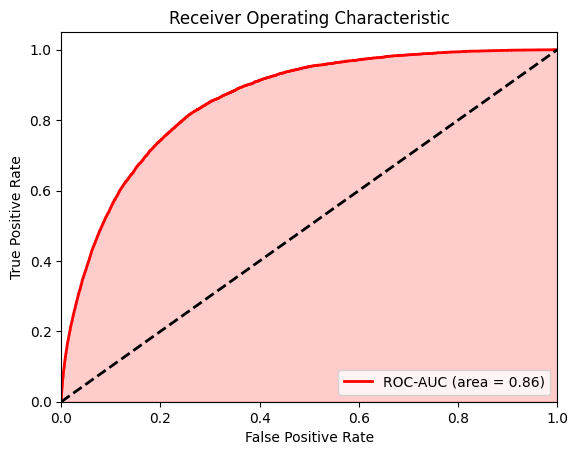

In [24]:
plot_roc(y_test, y_95)

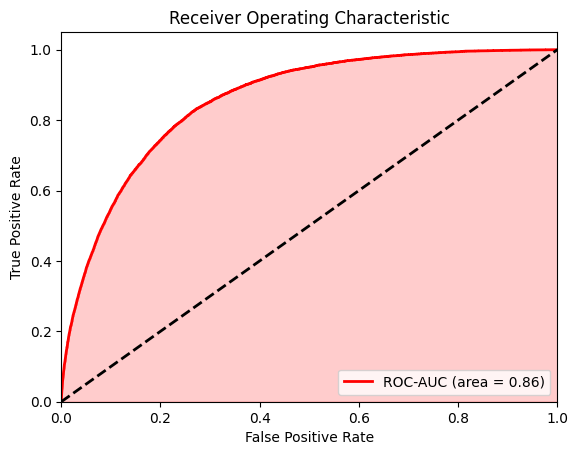

In [43]:
plot_roc(champ_predictions['target'], champ_predictions['lgb_pred'])

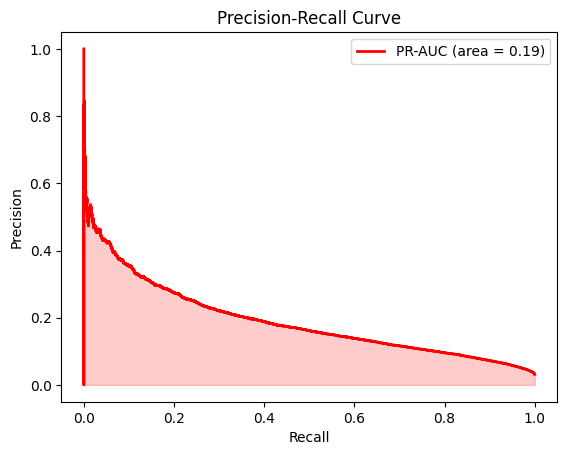

In [44]:
plot_pr(champ_predictions['target'], champ_predictions['lgb_pred'])

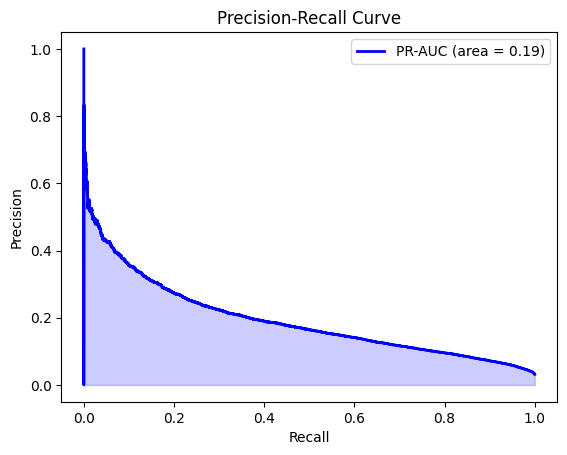

In [26]:
plot_pr(y_test, y_95, 'blue')

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

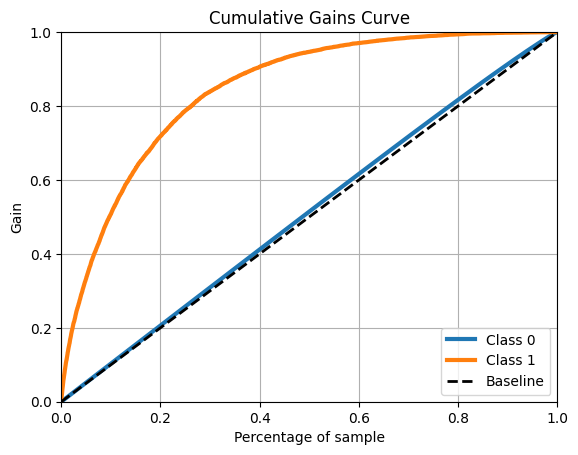

In [45]:
plot_cumulative_gain(champ_predictions['target'], np.vstack([1 - champ_predictions['lgb_pred'],  champ_predictions['lgb_pred']]).T)

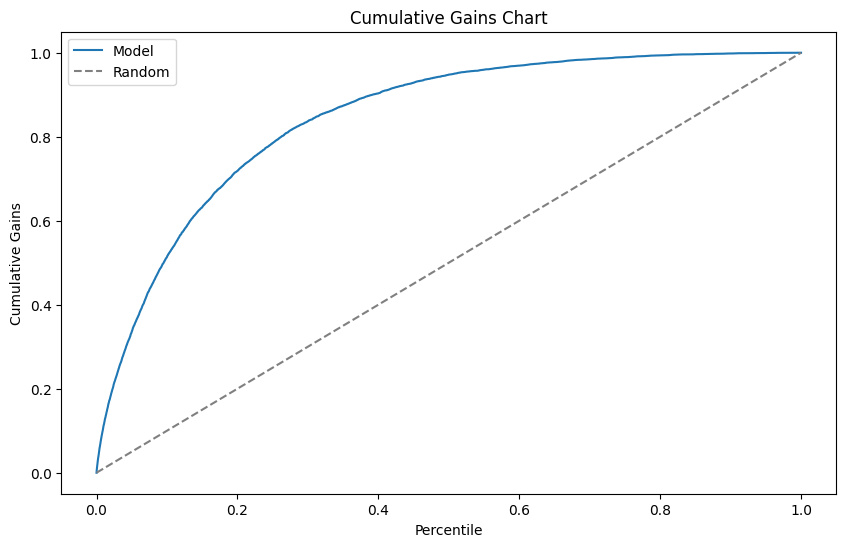

In [31]:

# Create a DataFrame to hold the data
data = pd.DataFrame({'y_actual': y_test, 'y_proba': y_95})

# Sort the data by predicted probability scores in descending order
data = data.sort_values(by='y_proba', ascending=False)

# Calculate cumulative gains
data['cumulative_actual'] = data['y_actual'].cumsum()
data['cumulative_percentage'] = data['cumulative_actual'] / data['y_actual'].sum()

# Create percentiles
data['percentile'] = np.arange(1, len(data) + 1) / len(data)

# Plot the cumulative gains chart
plt.figure(figsize=(10, 6))
plt.plot(data['percentile'], data['cumulative_percentage'], label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

plt.xlabel('Percentile')
plt.ylabel('Cumulative Gains')
plt.title('Cumulative Gains Chart')
plt.legend()
plt.show()

In [32]:
data

,y_actual,y_proba,cumulative_actual,cumulative_percentage,percentile
98732,0,0.802483,0,0.000000,0.000003
142716,1,0.798770,1,0.000105,0.000007
75509,1,0.798366,2,0.000209,0.000010
158560,1,0.787258,3,0.000314,0.000013
160320,1,0.786594,4,0.000419,0.000016
...,...,...,...,...,...
95921,0,0.000168,9553,1.000000,0.999987
287754,0,0.000167,9553,1.000000,0.999990
73078,0,0.000162,9553,1.000000,0.999993
194772,0,0.000160,9553,1.000000,0.999997


In [46]:
Model_Utils.cutoff_perc(champ_predictions['target'], champ_predictions['lgb_pred'], 0.2)

61066
0.0438188321454129


{'event_rate': 0.19999541482713898,
 'acc': 0.813665125175219,
 'precision': 0.11237206255629248,
 'recall': 0.7183083848005862,
 'f1': 0.1943413860488827,
 'roc_auc': 0.8561347087184998,
 'pr_auc': 0.18964341686977695,
 'lift': 3.5916242650934675}

In [17]:
import shap

X[cat_cols] = X[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')
# Initialize the explainer with the model and training data
explainer = shap.Explainer(champ_lgb)

# Compute SHAP values for the test data
shap_values = explainer(X_test)
# Summary plot
#shap.summary_plot(shap_values.values, X_test)



<Axes: xlabel='first_birth_259D', ylabel='lgb_pred'>

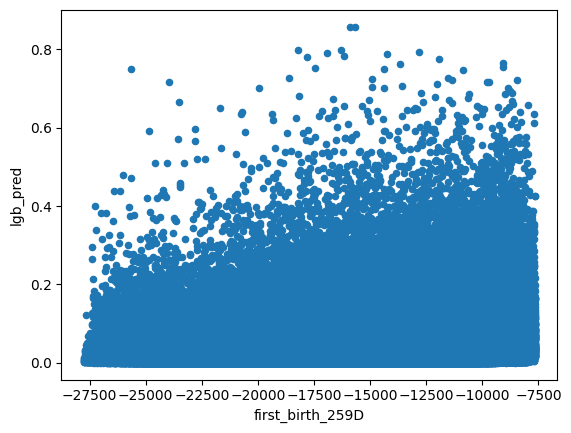

In [18]:
champ_predictions.plot.scatter(x = 'first_birth_259D', y = 'lgb_pred' )

In [41]:
shap_values.values

(305332, 450, 2)

In [49]:
shap_values.values.T[0].T.shape

(305332, 450)

In [51]:
'first_income_type_1044T' in X_test.columns

False

In [87]:
pd.DataFrame(X_test.groupby(['target'])['mean_outstandingdebt_522A'].mean())

,mean_outstandingdebt_522A
target,
0,7837.307860
1,11695.254429


In [70]:
stat = X_test.groupby(['min_education_1138M']).agg(count = pd.NamedAgg(column = 'case_id', aggfunc = 'count'),
                                       target = pd.NamedAgg(column = 'target', aggfunc = 'sum'))
stat['default'] = stat['target']/stat['count']
stat

,count,target,default
min_education_1138M,,,
None,60652,1313,0.021648
P106_81_188,6126,188,0.030689
P157_18_172,431,16,0.037123
P17_36_170,5019,194,0.038653
P33_146_175,89652,2320,0.025878
P97_36_170,131685,4865,0.036944
a55475b1,11767,657,0.055834


In [ ]:
5037/()

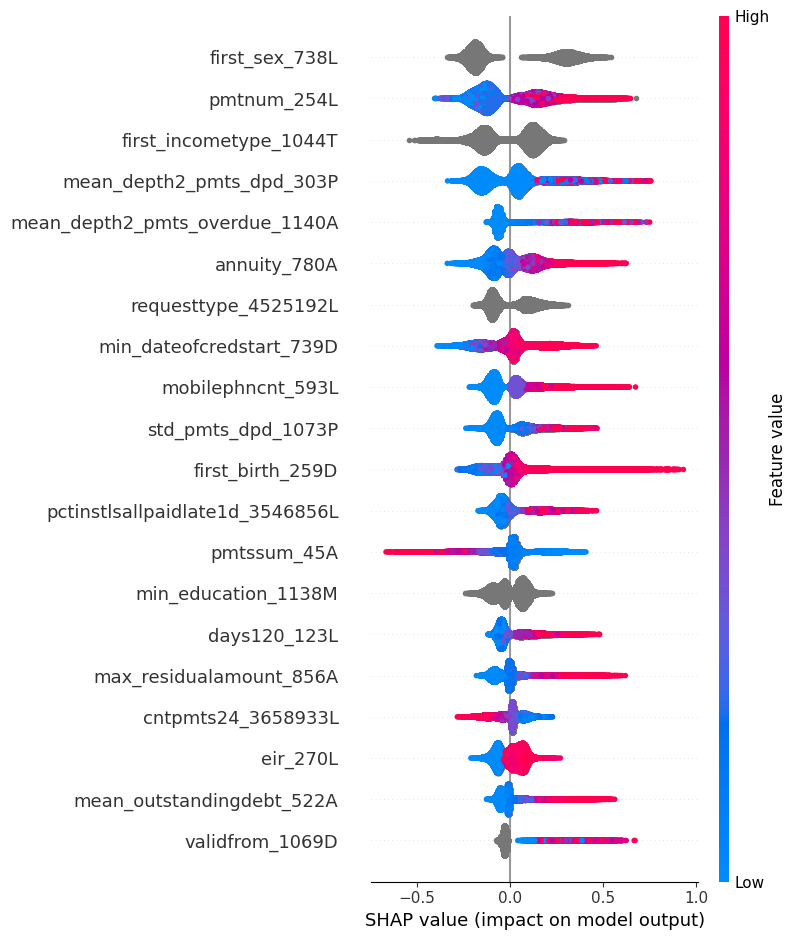

In [19]:
shap.summary_plot(shap_values.values.T[1].T, X_test, max_display = 20)

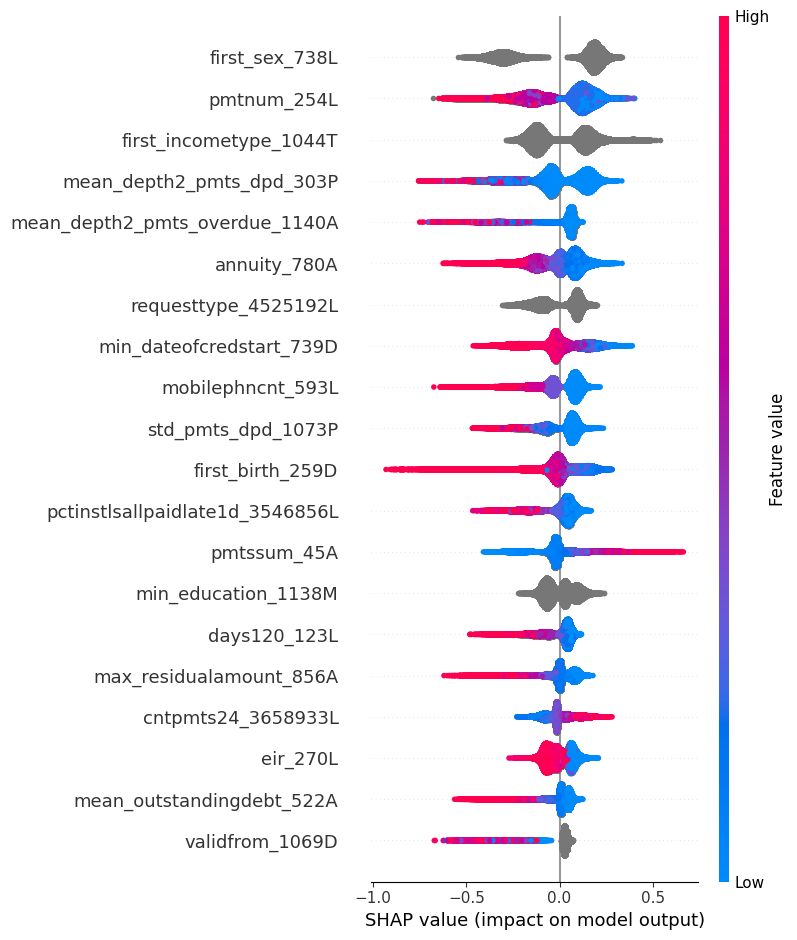

In [18]:
shap.summary_plot(shap_values.values.T[0].T, X_test, max_display = 20)

In [27]:
cum_lift = pd.DataFrame(columns = ['Cutoff', 'Event Rate', 'Accuracy', 'Precision', 'Recall', 'F1', 'Lift'])
cum_lift

,Cutoff,Event Rate,Accuracy,Precision,Recall,F1,Lift


In [28]:
for i in np.arange(0,1, 0.01):
    results = Model_Utils.cutoff_perc(y_test, y_95, i)
    row = [i]
    for metric, val in results.items():
        if metric in ['event_rate', 'acc', 'precision', 'recall', 'f1', 'lift']:
            row.append(val)
    cum_lift.loc[len(cum_lift)] = row

0
nan
3053
0.2663555751838629
6106
0.2034617095694355
9159
0.16894426944719032
12213
0.1456237511129337
15266
0.1284654594935345
18319
0.11488829580295086
21373
0.10439025603901453
24426
0.09531936756768149
27479
0.08734285260046598
30533
0.08085976979327827
33586
0.07508450898225646
36639
0.06994664858907769
39693
0.06542677601563292
42746
0.06138415404292714
45799
0.05766118988464319
48853
0.05432894462778716
51906
0.05123164092467502
54959
0.04851071990450721
58013
0.04599992691159599
61066
0.043641346934251334
64119
0.04145430656923578
67173
0.0394734303990101
70226
0.03758959115201056
73279
0.035826149593369626
76333
0.03415698899053401
79386
0.03258399698889869
82439
0.03113009035394423
85492
0.029712417473364214
88546
0.028367508958644153
91599
0.027170024492495275
94652
0.02602478441740472
97706
0.024951399723994926
100759
0.0238977965229868
103812
0.02291598358631935
106866
0.021984841160787687
109919
0.021093542726938114
112972
0.02021370939867063
116026
0.019407422762979624


In [39]:
for i in np.arange(0,1, 0.01):
    results = Model_Utils.cutoff_perc(champ_predictions['target'], champ_predictions['lgb_pred'], i)
    row = [i]
    for metric, val in results.items():
        if metric in ['event_rate', 'acc', 'precision', 'recall', 'f1', 'lift']:
            row.append(val)
    cum_lift.loc[len(cum_lift)] = row

0
nan
3053
0.2674311583954406
6106
0.2029711708141336
9159
0.1680098769134815
12213
0.1442248188823607
15266
0.1275467668094475
18319
0.114559217322978
21373
0.1038420223509952
24426
0.0949656954337582
27479
0.0874512539878511
30533
0.0808397760897607
33586
0.0751321462565902
36639
0.0700070882972314
39693
0.065546428992857
42746
0.0614661969165347
45799
0.0577771840103612
48853
0.054500402853472
51906
0.0513790436482804
54959
0.0486642122988426
58013
0.0461989381862554
61066
0.0438188321454129
64119
0.0416932694089234
67173
0.0396858245891356
70226
0.0378056487331795
73279
0.0360265665616611
76333
0.0343437405679803
79386
0.0327643675642302
82439
0.0312795500901318
85492
0.0298729679667114
88546
0.028515861060052
91599
0.0273172667138986
94652
0.0261979472828214
97706
0.0251353207998879
100759
0.0241094073365927
103812
0.02312361335416
106866
0.022161354295986
109919
0.0212316888557459
112972
0.0203642460930961
116026
0.0195715725757354
119079
0.0187880520232057
122132
0.0180321224251

In [29]:
cum_lift

,Cutoff,Event Rate,Accuracy,Precision,Recall,F1,Lift
0,0.00,0.000000,0.968713,0.000000,0.000000,0.000000,NaN
1,0.01,0.009996,0.965700,0.349279,0.111588,0.169139,11.163625
2,0.02,0.019995,0.960129,0.285340,0.182351,0.222506,9.120004
3,0.03,0.029994,0.953700,0.249727,0.239401,0.244455,7.981749
4,0.04,0.039996,0.946874,0.226990,0.290171,0.254721,7.255026
...,...,...,...,...,...,...,...
95,0.95,0.949995,0.081246,0.032910,0.999267,0.063721,1.051865
96,0.96,0.959994,0.071260,0.032574,0.999477,0.063092,1.041128
97,0.97,0.969997,0.061271,0.032245,0.999686,0.062475,1.030608
98,0.98,0.979996,0.051272,0.031916,0.999686,0.061857,1.020092


In [30]:
cum_lift.to_csv('gain_95.csv')

In [48]:
champ_predictions['rank_proba_lgb'] = 1-champ_predictions['lgb_pred'].rank(pct=True)

In [52]:
def impact_sizing(df, target_col, rank_col, impact_col, cutoff):
    df['pred'] = np.where(df[rank_col]<=cutoff, 1, 0)
    df['tag'] = np.where((df['pred'] == 1) & (df['target'] == 1), 'TP',
                          np.where((df['pred'] == 1) & (df['target'] == 0), 'FP', 
                                    np.where((df['pred'] == 0) & (df['target'] == 1), 'FN',
                                              np.where((df['pred'] == 0) & (df['target'] == 0), 'TN', None
                        ))))
    risk = len(df[(df['pred']==0) & (df['target']==1)])/(len(df[df['pred']==0]) + 0.000001)
    print(risk)
    return pd.DataFrame(df.groupby('tag')[impact_col].sum()).T

In [53]:
impact_sizing(champ_predictions, 'target', 'rank_proba_lgb', 'credamount_770A_y', 1)

0.0


tag,FP,TP
credamount_770A_y,1.468560e+10,5.362110e+08


In [52]:
champ_predictions[champ_predictions['rank_proba_lgb']<=0.1][]

,case_id,WEEK_NUM,target,catboost_pred,lgb_pred,credamount_770A_x,credamount_770A_y,avglnamtstart24m_4525187A,first_sex_738L,mean_depth2_pmts_dpd_303P,...,first_birth_259D.1,annuity_780A,min_dateofcredstart_739D,pmtnum_254L.1,max_dateofcredstart_739D,pmtssum_45A,min_dateofcredend_289D,max_residualamount_856A,lastapprcommoditycat_1041M,rank_proba_lgb
6,1808363,61,0,0.305482,0.227344,17154.0,17154.0,NaN,F,82.250000,...,-11207,1692.8000,-808.0,12.0,4.0,NaN,288.0,69853.484,a55475b1,0.015275
17,1746119,53,0,0.086265,0.153172,45200.0,45200.0,NaN,F,0.000000,...,-15504,4744.4000,-1621.0,12.0,-1621.0,NaN,571.0,0.000,P52_56_90,0.035823
18,1513338,34,1,0.154723,0.172718,9000.0,9000.0,NaN,F,92.812500,...,-16009,1859.8000,-1143.0,6.0,-743.0,6670.8003,-713.0,0.000,a55475b1,0.028359
27,232132,76,1,0.245139,0.182887,120000.0,120000.0,34797.800,F,3.271484,...,-24549,7334.4000,-88.0,36.0,-88.0,NaN,277.0,NaN,a55475b1,0.025222
42,1648395,46,0,0.151274,0.085160,27999.6,27999.6,NaN,F,NaN,...,-9459,2333.4001,-447.0,16.0,-139.0,NaN,40.0,6672.308,P159_130_59,0.093128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305281,879544,47,0,0.139330,0.103640,18782.0,18782.0,32762.201,F,NaN,...,-20666,1853.4000,-3040.0,12.0,-28.0,NaN,155.0,0.000,a55475b1,0.070186
305303,1722453,51,0,0.068117,0.115176,21998.0,21998.0,NaN,M,684.000000,...,-15978,1833.2001,NaN,12.0,NaN,NaN,NaN,NaN,a55475b1,0.059529
305315,2693605,85,0,0.080705,0.116812,60000.0,60000.0,NaN,M,359.250000,...,-21356,3600.0000,-730.0,NaN,-730.0,NaN,853.0,NaN,P33_29_177,0.058153
305326,1912520,87,0,0.169874,0.154256,74996.0,74996.0,NaN,M,8.812500,...,-21428,3125.0000,-2544.0,24.0,-2544.0,NaN,377.0,0.000,a55475b1,0.035378


In [54]:
champ_predictions.columns

Index(['case_id', 'WEEK_NUM', 'target', 'catboost_pred', 'lgb_pred',
       'credamount_770A_x', 'credamount_770A_y', 'avglnamtstart24m_4525187A',
       'first_sex_738L', 'mean_depth2_pmts_dpd_303P', 'pmtnum_254L',
       'maxdpdlast24m_143P', 'first_birth_259D', 'first_incometype_1044T',
       'mean_depth2_pmts_overdue_1152A', 'max_numberofcontrsvalue_358L',
       'price_1097A', 'max_totalamount_6A', 'first_birth_259D.1',
       'annuity_780A', 'min_dateofcredstart_739D', 'pmtnum_254L.1',
       'max_dateofcredstart_739D', 'pmtssum_45A', 'min_dateofcredend_289D',
       'max_residualamount_856A', 'lastapprcommoditycat_1041M',
       'rank_proba_lgb'],
      dtype='object')